# Using the VGG-16 Pre-Trained NN
This notebook will use the VGG-16 pre-trained neural network to make age group classifications on the dataset. This score will be compared to the baseline neural network. Later, this neural network will be tweaked to improve performance.

In [25]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dropout, Flatten, Dense, BatchNormalization
from keras_vggface.vggface import VGGFace
from keras import applications
from keras.utils.vis_utils import plot_model
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Running the Pre-Trained VGG-16 CNN Model

In [26]:
# dimensions of our images.
img_width, img_height = 224,224

train_data_dir = '../classification_data/train'
test_data_dir = '../classification_data/test'
final_data_dir = '../classification_data/final_test'
epochs = 5
batch_size = 32
input_shape = (224,224,3)

### Model Topology

Prorposed Topology
- VGG-16
- Flatten()
- Dense (4096, relu)
- Dense (4096, relu)
- Dense (8, softmax)

In [4]:
# The original VGG-16 model has 16 separate weight layers, including three
# fully connected layers at the end. include_top = False allows me to 
# not have the last three fully connected layers and instead I can create my own
vgg_model = VGGFace(include_top = False, 
                    weights = 'vggface', 
                    input_shape= input_shape)

In [5]:
# Initialize model
model = Sequential()

# Input layer
model.add(BatchNormalization(input_shape=input_shape))

# VGG-16 pre-trained layer
model.add(vgg_model)

# Adding first dense layer to flatten convolutional layers
model.add(Flatten())  
model.add(Dense(4096, activation='relu'))

# Adding second dense layer
model.add(Dense(2048, activation='relu'))

# Adding output layer, to output class
model.add(Dense(8, activation='softmax'))

# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#### Summary of the topology of the model

In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 224, 224, 3)       12        
_________________________________________________________________
vggface_vgg16 (Model)        (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              102764544 
_________________________________________________________________
dense_2 (Dense)              (None, 2048)              8390656   
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 16392     
Total params: 125,886,292
Trainable params: 125,886,286
Non-trainable params: 6
______________________________________________________________

### Reading in the data

In [27]:
# this is the augmentation configuration we will use for training
datagen = ImageDataGenerator()

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = datagen.flow_from_directory(
        directory=train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle = True)

# this is a similar generator, for test data
test_generator = datagen.flow_from_directory(
        directory=test_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle = False)

# this the final generator, for final test data
final_generator = datagen.flow_from_directory(
        directory=final_data_dir,
        target_size=(img_width, img_height),
        batch_size=5,
        class_mode='categorical',
        shuffle = False)

Found 73411 images belonging to 8 classes.
Found 8530 images belonging to 8 classes.
Found 5 images belonging to 8 classes.


In [8]:
# Loading the saved model for further training
# If running the model for the first time, skip this cell

model = load_model('aws_vgg_model_saved_again.h5')

In [10]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch= 73411//batch_size,
        epochs=epochs)

Epoch 1/5
2294/2294 [==============================] - 1903s 829ms/step - loss: 0.8508 - acc: 0.6193
Epoch 2/5
2294/2294 [==============================] - 1902s 829ms/step - loss: 0.8467 - acc: 0.6183
Epoch 3/5
2294/2294 [==============================] - 1901s 829ms/step - loss: 0.8246 - acc: 0.6297
Epoch 4/5
2294/2294 [==============================] - 1902s 829ms/step - loss: 0.8201 - acc: 0.6316
Epoch 5/5
2294/2294 [==============================] - 1902s 829ms/step - loss: 0.8036 - acc: 0.6398


Model Learning Progress:
- At the end of five epochs, the model is at a loss score of 1.0296 and an accuracy score of 53.84%. 
- The model was ran for 10 more epochs (for a total of 15 epochs) with a loss score of 0.8661 and an accuracy score of 60.92%. 
- The model was ran for 5 more epochs (for a total of 20 epochs) with a loss score of 0.8036 and an accuracy score of 0.6398

### Evaluate the Model

In [11]:
# evaluate the model
loss, acc = model.evaluate_generator(test_generator, steps=8530// batch_size)
print('Cross-entropy: ', loss)
print('Accuracy: ', acc)

Cross-entropy:  1.097607985811126
Accuracy:  0.5054041353383458


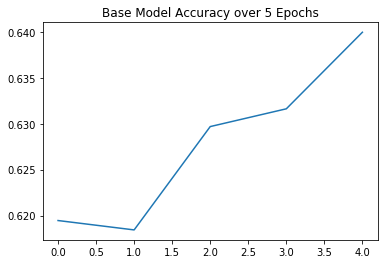

In [14]:
plt.plot(history.history['acc'])
plt.title('Base Model Accuracy over 5 Epochs')
plt.savefig('../images/aws_vgg_model_acc.png', bbox_inches='tight')

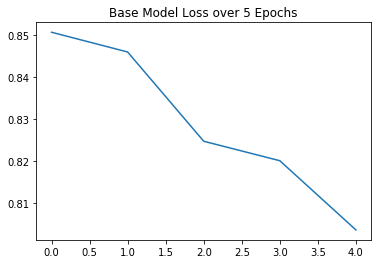

In [15]:
plt.plot(history.history['loss'])
plt.title('Base Model Loss over 5 Epochs')
plt.savefig('../images/aws_vgg_model_loss.png', bbox_inches='tight')

### Saving the model and weights

In [16]:
# serialize model to JSON
base_model_json = model.to_json()
with open("../models_and_weights/aws_vgg_model.json", "w") as json_file:
    json_file.write(base_model_json)
    
# serialize weights to HDF5
model.save_weights("../models_and_weights/aws_vgg_model.h5")
print("Saved model to disk")

Saved model to disk


In [17]:
model.save('../models_and_weights/aws_vgg_model_saved_again.h5')

In [18]:
%%time
test_generator.reset()
pred=model.predict_generator(test_generator, np.ceil(8530/batch_size))

CPU times: user 17.9 s, sys: 2.43 s, total: 20.3 s
Wall time: 1min


In [19]:
labels = (test_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in np.argmax(pred,axis=1)]

In [20]:
filenames=test_generator.filenames

In [21]:
classes = [x.split('/')[0] for x in filenames]

In [22]:
results=pd.DataFrame({"Filename":classes, "Predictions":predictions})

In [23]:
results.to_csv('../results/vgg16_20.csv',index=False)

In [24]:
results

,Filename,Predictions
0,0-10,0-10
1,0-10,0-10
2,0-10,0-10
3,0-10,31-40
4,0-10,0-10
5,0-10,21-30
6,0-10,11-20
7,0-10,0-10
8,0-10,0-10
9,0-10,0-10


### Final predictions

In [37]:
len(predictions)

5

In [38]:
len(classes)

5

In [36]:
final_pred=model.predict_generator(final_generator, 1)
labels = (final_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in np.argmax(final_pred,axis=1)]
filenames=final_generator.filenames
classes = [x.split('/')[0] for x in filenames]
results=pd.DataFrame({"Filename":classes, "Predictions":predictions})
results.to_csv('../results/final_vgg16.csv',index=False)

In [39]:
results

,Filename,Predictions
0,11-20,11-20
1,21-30,21-30
2,31-40,31-40
3,51-60,31-40
4,61-70,11-20
